# Predição do preço do Bitcoin com uma RNN

![](bitcoin.png)

Bitcoin é uma moeda digital do tipo criptomoeda descentralizada, e também um sistema econômico alternativo, apresentada em 2008 na lista de discussão The Cryptography Mailing por um programador, ou um grupo de programadores, de pseudônimo Satoshi Nakamoto; É considerada a primeira moeda digital mundial descentralizada, e tida como responsável pelo ressurgimento do sistema bancário livre.
https://pt.wikipedia.org/wiki/Bitcoin

![](bitcoinhist.png)

Série histórica do valor do bitcoin desde 14 Jan 2014
https://coinmarketcap.com/

Vamos utilizar a série histórica para treinar uma Rede Neural Recorrente com o objetivo de prever 1 mes do valor da moeda


### Roteiro

* Analisar o Dataset com a série histórica do preço do bitcoin
* Preparar o Dataset para utilização pela noss RNN
* Criar uma LSTM para previsão do preço do bitcoin
* Usar a nossa rede neural para prever 1 mês do valor da moeda

### Bibliotecas

In [1]:
# geral
import math
import pandas as pd
from numpy import concatenate
from datetime import datetime

# ML
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Visualizacao
from matplotlib import pyplot
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

py.init_notebook_mode(connected=True)
sns.set(style="whitegrid")
%matplotlib inline

Using TensorFlow backend.


In [2]:
np.random.seed(42)

### Dataset - coinmarketcap

In [3]:
df = pd.read_csv(filepath_or_buffer="data_bitcoin.csv", index_col="Date")

In [4]:
df.tail()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2017-11-15,6660.6,7300.0,6660.6,7260.0,7650.858383,5.417746e+07,7081.226281
2017-11-16,7260.0,7790.0,7085.2,7750.7,8575.163873,6.375057e+07,7434.327022
2017-11-17,7755.7,7950.0,7520.2,7695.7,5630.447920,4.388672e+07,7794.534086
2017-11-18,7691.9,7849.9,7426.9,7786.0,2972.039159,2.276482e+07,7659.664424
2017-11-19,7790.5,7790.5,7785.2,7786.0,0.979734,7.628664e+03,7786.467641


In [5]:
df.shape

(1413, 7)

In [6]:
btc_trace = go.Scatter(x=df.index, y=df['Close'], name= 'Price')
py.iplot([btc_trace])

Alguns registros estão sem o valor do bitcoin no dia (close). Para minimizar o efeito dessas inconsistências na nossa análise, vamos preencher com o último valor válido  

In [7]:
df['Close'].replace(0, np.nan, inplace=True)
df['Close'].fillna(method='ffill', inplace=True)

In [8]:
btc_trace = go.Scatter(x=df.index, y=df['Close'], name= 'Price')
py.iplot([btc_trace])

Iremos utilizar apenas as informações do **preço de fechamento da moeda no dia (df.Close)**. A intenção é prever esse valor usando apenas os dados históricos do mesmo valor.

### Criaremos o dataset de treinamento e de teste a partir dos dados históricos

O valor que pretendemos prever é o de **Fechamento do dia**

In [9]:
values = df.Close.values.reshape(-1,1)
values

array([[  810.     ],
       [  824.98287],
       [  841.86934],
       ..., 
       [ 7695.7    ],
       [ 7786.     ],
       [ 7786.     ]])

Normalização dos dados por desvio padrão:

In [10]:
scaler        = StandardScaler()
scaled_values = scaler.fit_transform(values)

Separação dos dados de **treinamento** e de **teste**. Utilizaremos **2 meses** para teste e o resto para treinamento

In [11]:
train_size = len(scaled_values)-30
test_size  = len(scaled_values) - train_size

train, test = scaled_values[0:train_size,:], scaled_values[train_size:len(scaled_values),:]
print("Treinamento:", len(train))
print("Teste:", len(test))

Treinamento: 1383
Teste: 30


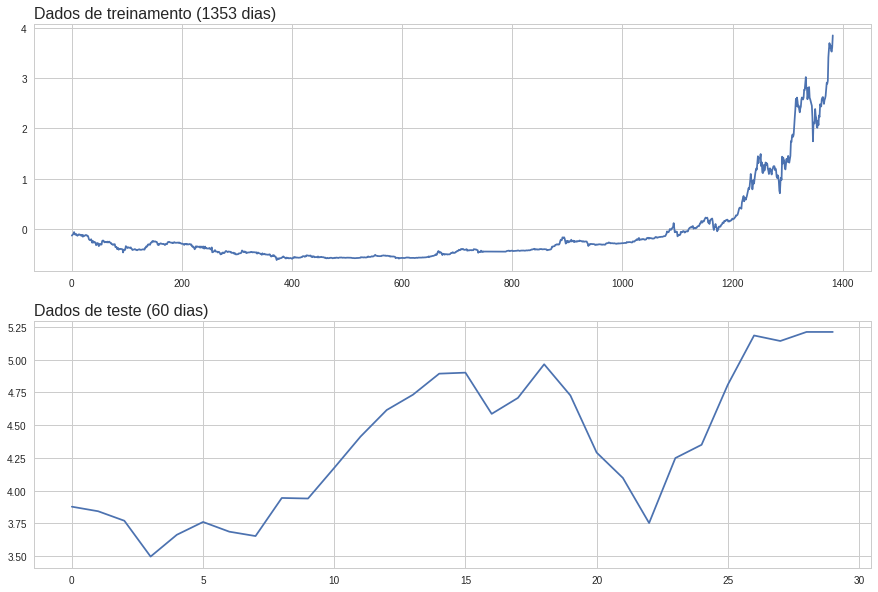

In [12]:
# Plot grafico treinamento e teste
fig = plt.figure(figsize=(15,10))
ax = plt.subplot(211)
ax.set_title('Dados de treinamento (1353 dias)', loc='left', fontsize=16)
plt.plot(train)

ax = plt.subplot(212)
ax.set_title('Dados de teste (60 dias)', loc='left', fontsize=16)
plt.plot(test)

Como é uma previsão de série histórica, precisamos criar o dataset que reflita a previsão. Ou seja, dado $$x(t-2), x(t-1), x(t)$$ devemos prever $$x(t+1)$$

![](img2.png)

In [13]:
# Monta o dadaset de X, Y com atraso 
def dataset_with_look_back(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [14]:
dataset = np.array([1, 2, 3, 4, 5]).reshape(-1,1)

datasetX, datasetY = dataset_with_look_back(dataset, 1)

print('dataset: ', list(dataset.reshape(1,-1)[0]))
print('datasetX: ',list(datasetX.reshape(1,-1)[0]))
print('datasetY: ',list(datasetY))

dataset:  [1, 2, 3, 4, 5]
datasetX:  [1, 2, 3, 4]
datasetY:  [2, 3, 4, 5]


Cria o valor de entrada (X) e o de saida (Y) para os dados de treinamento e test

In [15]:
# Janela de entrada para a rede, 10 dias
look_back = 1

trainX, trainY = dataset_with_look_back(train, look_back)
testX, testY  = dataset_with_look_back(test, look_back)

trainX.shape

(1382, 1)

A rede LSTM espera que os dados de entrada (X) sejam fornecidos com uma estrutura de matriz específica na forma de: ***[samples, time steps, features]***.

In [16]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX  = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

trainX.shape

(1382, 1, 1)

### Agora que o dataset já está criado, vamos montar o modelo LSTM e realizar o treinamento

In [17]:
model = Sequential()

# 100 LSTM blocks
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))

# 10% of dropout 
model.add(Dropout(0.1))

# MLP FullyConnect
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='rmsprop')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


#### Treinamento

In [18]:
# Params
epochs     = 10
batch_size = 10

# Train
history = model.fit(trainX, trainY, 
                    epochs=epochs, batch_size=batch_size, 
                    validation_data=(testX, testY), 
                    shuffle=False)

Train on 1382 samples, validate on 29 samples
Epoch 1/10
1382/1382 [==============================] - 2s - loss: 0.1778 - val_loss: 6.2157
Epoch 2/10
1382/1382 [==============================] - 1s - loss: 0.0333 - val_loss: 0.5592
Epoch 3/10
1382/1382 [==============================] - 1s - loss: 0.0083 - val_loss: 0.1637
Epoch 4/10
1382/1382 [==============================] - 1s - loss: 0.0039 - val_loss: 0.1506
Epoch 5/10
1382/1382 [==============================] - 1s - loss: 0.0031 - val_loss: 0.1443
Epoch 6/10
1382/1382 [==============================] - 1s - loss: 0.0032 - val_loss: 0.1372
Epoch 7/10
1382/1382 [==============================] - 1s - loss: 0.0029 - val_loss: 0.1256
Epoch 8/10
1382/1382 [==============================] - 1s - loss: 0.0031 - val_loss: 0.1168
Epoch 9/10
1382/1382 [==============================] - 1s - loss: 0.0033 - val_loss: 0.1495
Epoch 10/10
1382/1382 [==============================] - 1s - loss: 0.0029 - val_loss: 0.0951


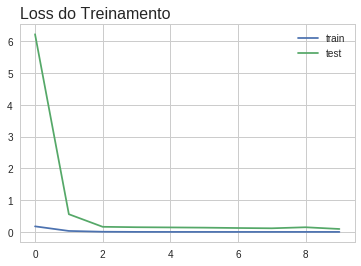

In [19]:
# Hisorico de treinamento
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Loss do Treinamento', loc='left', fontsize=16)
plt.legend()

Usando o modelo para predição dos dados de **Teste (dois últimos meses)**. Após predição, inverte a normalização dos dados para voltar ao valor original

In [20]:
# make predictions
trainPredict = model.predict(trainX)
testPredict  = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY       = scaler.inverse_transform([trainY])
testPredict  = scaler.inverse_transform(testPredict)
testY        = scaler.inverse_transform([testY])

Calcula o ***RMSE*** dos dados de treinamento e teste

In [21]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 110.44 RMSE
Test Score: 402.78 RMSE


### Exibe o modelo ajustado aos dados de treinamento e a predição dos últimos dois meses

In [22]:
predictDates  = df.tail(len(trainX)).index
actual_chart  = go.Scatter(x=predictDates, y=trainY[0], name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=trainPredict[:,0], name= 'Predict Price')
py.iplot([predict_chart, actual_chart])

Ajuste do modelo aos dados de treinamento (1353 dias)

#### Previsão dos últimos 2 meses

In [23]:
predictDates = df.tail(len(testX)).index

actual_chart = go.Scatter(x=predictDates, y=testY[0], name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=testPredict[:,0], name= 'Predict Price')
py.iplot([predict_chart, actual_chart])

## + Links

* https://matheusfacure.github.io/2017/02/16/rnn-poesia/
* https://medium.com/mlreview/understanding-lstm-and-its-diagrams-37e2f46f1714
* https://www.youtube.com/watch?v=UNmqTiOnRfg&t=646s